<h3>In this notebook, we're going to use Pytorch to train a few classifiers for the Fashion-MNIST dataset.</h3>

The classifiers we'll implement are: 

1. Linear Classifier (Logistic Regression as a Neural Network)

2. Deep Neural Network (Adding non-linearity via an activation function)

3. A DNN with a different parameter initialization (Xavier initialization)

4. A DNN with l2 regularization (weight decay)

5. A DNN with dropout




<p>While these are a total of 5 classifiers, the differences in implementation are a few lines at most, sometimes even a single argument!

Note: It's generally unadvisable to flatten images into a single dimension and treat them as a 1D vector without exploiting the spatial structrue in the image in a more satisfying way. 

We do this here for practice and for educational purposes, but a better way is to use Convolutional Neural Networks, which we discuss later.</p>

Also note that all networks will take from 2 to 10 minutes to train. This is because we're training on CPU which generally uses much more time for neural network training than a GPU.

We'll start by importing PyTorch and some additional packages we'll need:

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# set default device based on CUDA's availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

#Dataset Class

Next we'll define our dataset class. The dataset we're using is Fashion-MNIST, which is included in torchvision's datasets. We just have to call the appropiate function to downlaod it.

We also make use of torchvision's transforms module to prepare the images by resizing them if needed and converting the to Pytorch tensors.

We use torch's built-in DataLoader to get dataloaders for the training and validation sets and add some helper methods for visualizing the dataset.

In [2]:
class FashionMNIST(Dataset):
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28), root=".", num_workers=2):
        super().__init__()

        self.batch_size = batch_size
        self.resize = resize
        self.root = root
        self.num_workers = num_workers

        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)


    def text_labels(self, indices):
      """Return text labels."""
      labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
      return [labels[int(i)] for i in indices]


    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                          num_workers=self.num_workers)

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def show_images(self, imgs, num_rows, num_cols, titles=None, scale=1.5):
        figsize = (num_cols * scale, num_rows * scale)
        _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
        axes = axes.flatten()
        for i, (ax, img) in enumerate(zip(axes, imgs)):
            try:
                img = np.array(img)
            except:
                pass
            ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            if titles:
                ax.set_title(titles[i])
        return axes

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        self.show_images(X.squeeze(1), nrows, ncols, titles=labels)

Now we can instantiate the dataset class and get some batches of data and visualize them.

In [3]:
data = FashionMNIST()
#Total number of training, validation examples
len(data.train), len(data.val)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



(60000, 10000)

In [4]:
#Shape of a single image
data.train[0][0].shape

torch.Size([1, 28, 28])

In [5]:
X, y = next(iter(data.train_dataloader()))
#Shape of a single batch with batch size = 64
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 28, 28]) torch.float32 torch.Size([64]) torch.int64


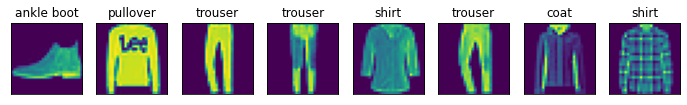

In [6]:
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

#First classifier: Linear Network

We'll start by defining our first classifier: a simple logistic regression model implemented as a neural network with a single linear layer.


Note that in PyTorch we don't explicitly include the nn.Softmax in the net architecture. This is because PyTorch's built-in [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) expects the input to be unnormalized logits (i.e normal linear layer output without applying softmax)

We don't need to apply Softmax during validation unless we require class probabilities, otherwise we can just get the maximum probability class with argmax in which case we don't need to calculate the Softmax before (as Softmax preserves ordering so the max argument before Softmax is the same after)



**Q1: Implement a linear neural network for classification**

In [7]:
class SoftmaxRegression(nn.Module):  
    def __init__(self, num_outputs, lr):
        super().__init__()

        self.num_outputs=num_outputs
        self.lr = lr


        self.net = nn.Sequential(
          #TODO: Add a nn.Flatten() layer
          nn.Flatten(),
          
          #TODO: Add a nn.Linear layer after it with input 28*28
          #      and output=num_outputs'
          nn.Linear(28*28,num_outputs)

        )

    def forward(self, X):
        return self.net(X)

    def loss(self, Y_hat, Y, averaged=True):
      Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
      Y = Y.reshape((-1,))
      return F.cross_entropy(
          Y_hat, Y, reduction='mean' if averaged else 'none')

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)



Now what remains is to define the trainer class. Note that you can directly write the training loop without wrapping it in a class, but doing it this way is cleaner and more modular. We will use this same trainer class to train all classifiers in this notebook without having to rewrite it.

**Q2: Complete the Trainer class**

In [8]:
class Trainer:
    def __init__(self, max_epochs, num_gpus=0):
        assert num_gpus == 0, 'No GPU support yet'

        self.max_epochs = max_epochs

        #We use those lists to plot the loss and accuracy
        self.train_losses = []
        self.val_losses = []

        self.train_acc = []
        self.val_acc = []


    def prepare_data(self, data):

      self.train_dataloader = data.train_dataloader()
      self.val_dataloader = data.val_dataloader()

      self.num_train_batches = len(self.train_dataloader)
      self.num_val_batches = (len(self.val_dataloader)
                              if self.val_dataloader is not None else 0)
        

    def fit(self, model, data):

        self.prepare_data(data)
        self.model = model
        self.optim = model.configure_optimizers()

        self.epoch = 0
        self.batch_size = data.batch_size

        #Train for max_epochs epochs
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

        self.plot_loss()
        self.plot_accuracy()
        self.visualize_wrong()

    def fit_epoch(self):
        #TODO: Call the train() method of self.model
        
        self.model.train()

        running_loss = 0
        running_acc = 0

        for batch in self.train_dataloader:

            X, y = batch

            #TODO: Calculate y_hat by applying self.model on X
            y_hat = self.model(X)


            #TODO: Calculate loss by calling self.model.loss
            loss = self.model.loss(y_hat,y)


            #Accumulate loss each batch in running_loss
            running_loss += loss.item()

            #TODO: Get predictions by calling torch.argmax on y_hat with axis=1
            predicted = torch.argmax(y_hat,axis=1)

            #Calculate average accuracy for a single batch
            running_acc += (predicted == y).sum().item() / self.batch_size

            #TODO: Zero out self.optim's gradient with the zero_grad() method
            self.optim.zero_grad()


            #TODO: Call loss.backward 

            loss.backward()


            #TODO: Call self.optim's step method

            self.optim.step()


        #Divide loss and accuracy by number of training batches per epoch
        running_loss /= self.num_train_batches
        running_acc /= self.num_train_batches

        self.train_losses.append(running_loss)
        self.train_acc.append(running_acc)

        #TODO: Call the eval() method of self.model

        self.model.eval()

        val_running_loss = 0
        val_running_acc = 0

        for batch in self.val_dataloader:
            with torch.no_grad():

                X, y = batch

                #TODO: Calculate y_hat by applying self.model on X
                y_hat = self.model(X)
                #TODO: Calculate loss by calling self.model.loss
                loss = self.model.loss(y_hat,y)
                #TODO: Get predictions by calling torch.argmax on y_hat with axis=1    
                predicted = torch.argmax(y_hat,axis=1)

                val_running_acc += (predicted == y).sum().item() / self.batch_size

                val_running_loss += loss.item()
        
        val_running_loss /= self.num_val_batches
        val_running_acc /= self.num_val_batches

        self.val_losses.append(val_running_loss)
        self.val_acc.append(val_running_acc)

        print(f"Epoch: {self.epoch}, train loss: {running_loss}, val loss: {val_running_loss} \
                train acc: {running_acc} val acc: {val_running_acc}")


    def plot_loss(self):
      """Plot loss for each epoch"""
      plt.plot(self.train_losses, label='train loss')
      plt.plot(self.val_losses, label='val loss', )
      plt.legend()
      plt.show()

    def plot_accuracy(self):
      """Plot accuracy for each epoch"""
      plt.plot(self.train_acc, label='train accuracy')
      plt.plot(self.val_acc, label='val accuracy')
      plt.legend()
      plt.show()

    def visualize_wrong(self):
      """Visualize wrong examples for a single batch
          The first line is the true class and 
          the second is the predicted class"""
      X, y = next(iter(self.val_dataloader))
      preds = self.model(X).argmax(axis=1)

      wrong = preds.type(y.dtype) != y
      X, y, preds = X[wrong], y[wrong], preds[wrong]
      labels = [a+'\n'+b for a, b in zip(
          data.text_labels(y), data.text_labels(preds))]
      data.visualize([X, y], labels=labels)

    

Now for the training part. We instantiate the dataset, model, and trainer classes, and call the fit method of the trainer class on the model and the data.

**Q3: Initialize the dataset class, model, trainer, and finall call the fit method of the trainer**

Epoch: 0, train loss: 0.7838152570927397, val loss: 0.6238430611789226                 train acc: 0.7470412234042553 val acc: 0.76884765625
Epoch: 1, train loss: 0.569829231627444, val loss: 0.5686276674270629                 train acc: 0.8114029255319148 val acc: 0.7875
Epoch: 2, train loss: 0.5261611929599275, val loss: 0.5443668819963932                 train acc: 0.8228889627659575 val acc: 0.79169921875
Epoch: 3, train loss: 0.5007109904542882, val loss: 0.522138586640358                 train acc: 0.8303523936170213 val acc: 0.79765625
Epoch: 4, train loss: 0.48534999109329063, val loss: 0.5017861992120742                 train acc: 0.8347573138297872 val acc: 0.80751953125
Epoch: 5, train loss: 0.4739918569301037, val loss: 0.4946203611791134                 train acc: 0.8381815159574468 val acc: 0.8099609375
Epoch: 6, train loss: 0.4652881210154675, val loss: 0.4983667865395546                 train acc: 0.8400099734042553 val acc: 0.80810546875
Epoch: 7, train loss: 0.45785472

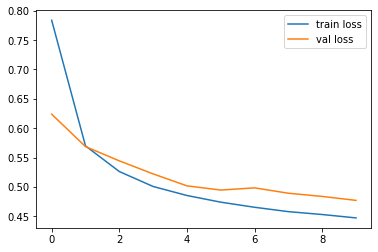

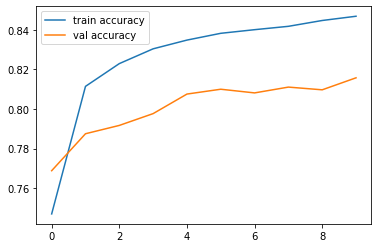

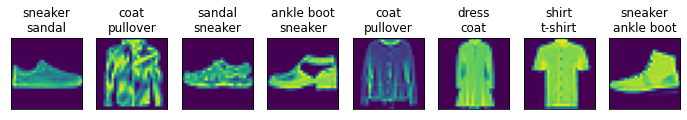

In [9]:
data = FashionMNIST(batch_size=256) #TODO: Instantiate the dataset class defined above with batch_size=256
model = SoftmaxRegression(num_outputs = 10, lr=0.1) #TODO: Instantiate the model class with num_outputs=10 and lr=0.1
trainer = Trainer(max_epochs=10) #TODO: Instantiate the trainer class with max_epochs = 10


#TODO: Call the fit method of the trainer class

trainer.fit(model,data)


#Second Classifier: Multilayer Perceptron (MLP) 

**Q4: Implement MLP by adding a hidden layer and a ReLU activation to the Linear Model**

Epoch: 0, train loss: 0.8668593482768282, val loss: 0.6967924989759922                 train acc: 0.7114527925531915 val acc: 0.7423828125
Epoch: 1, train loss: 0.5585837388292272, val loss: 0.5512487336993217                 train acc: 0.8056682180851064 val acc: 0.7888671875
Epoch: 2, train loss: 0.493523745080258, val loss: 0.5549306638538838                 train acc: 0.8250997340425532 val acc: 0.77080078125
Epoch: 3, train loss: 0.4620786872315914, val loss: 0.4668516732752323                 train acc: 0.8362865691489362 val acc: 0.81357421875
Epoch: 4, train loss: 0.4379507520097367, val loss: 0.45173043459653855                 train acc: 0.8445146276595744 val acc: 0.8224609375
Epoch: 5, train loss: 0.42083931755512316, val loss: 0.45128542333841326                 train acc: 0.8494847074468085 val acc: 0.8189453125
Epoch: 6, train loss: 0.40435027175761284, val loss: 0.47928392663598063                 train acc: 0.8557347074468085 val acc: 0.8041015625
Epoch: 7, train loss:

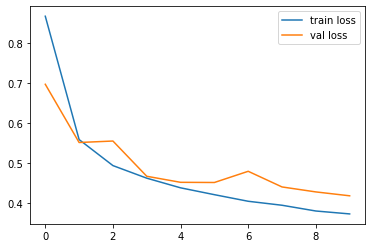

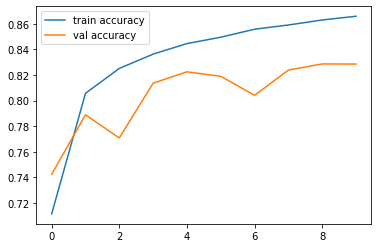

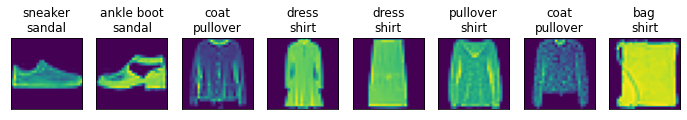

In [10]:
class MLP(nn.Module):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()

        self.num_num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        self.lr = lr

        self.net = nn.Sequential(
        #TODO: Add a nn.Flatten()
        nn.Flatten(),
        #TODO: Add a nn.Linear with input=28*28 and output=num_hiddens
        nn.Linear(28*28,num_hiddens),
        #TODO: Add a nn.ReLU after the Linear Layer you define
        nn.ReLU(),
        #TODO: Add a nn.Linear with input=num_hiddens and output=num_outputs
        nn.Linear(num_hiddens,num_outputs)                        
                                 )

    def forward(self, X):
        return self.net(X)

    def loss(self, Y_hat, Y, averaged=True):
      Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
      Y = Y.reshape((-1,))
      return F.cross_entropy(
          Y_hat, Y, reduction='mean' if averaged else 'none')

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)


data = FashionMNIST(batch_size=256)
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

#Third Classifier: MLP with Xavier initialization

**Q5: Add Xavier initialization to the MLP**

To apply Xavier initialization we define the net as usual and then call the apply method of the net which applies its argument to all layers in the model. 

We check if the layer in question is a Linear layer and if so we call `torch.nn.init.xavier_uniform_` on layer.weight to update it in place.

Epoch: 0, train loss: 0.7374781428499425, val loss: 0.5659104295074939                 train acc: 0.7513630319148936 val acc: 0.7853515625
Epoch: 1, train loss: 0.5161543371829581, val loss: 0.5551540911197662                 train acc: 0.8202460106382978 val acc: 0.781640625
Epoch: 2, train loss: 0.4655065064734601, val loss: 0.4863372042775154                 train acc: 0.8355385638297872 val acc: 0.8013671875
Epoch: 3, train loss: 0.43103707242519296, val loss: 0.4400090955197811                 train acc: 0.8481382978723404 val acc: 0.8265625
Epoch: 4, train loss: 0.4111545115075213, val loss: 0.4658983923494816                 train acc: 0.8534906914893617 val acc: 0.81435546875
Epoch: 5, train loss: 0.39502457748068137, val loss: 0.439868588373065                 train acc: 0.8599235372340426 val acc: 0.82001953125
Epoch: 6, train loss: 0.37908854465535347, val loss: 0.4094408810138702                 train acc: 0.8642785904255319 val acc: 0.83505859375
Epoch: 7, train loss: 0.36

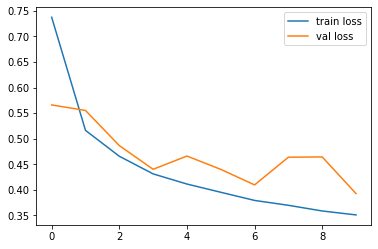

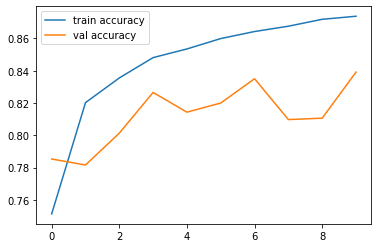

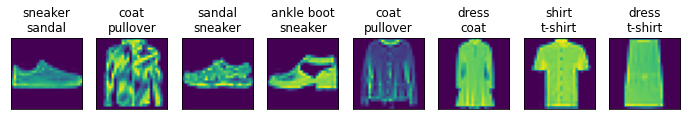

In [11]:
class MLPXavier(nn.Module):
    def __init__(self, num_outputs, num_hiddens, lr):
      super().__init__()

      self.num_num_outputs = num_outputs
      self.num_hiddens = num_hiddens
      self.lr = lr

      #TODO: Use the same net you used in Q4
      self.net = nn.Sequential(
        #TODO: Add a nn.Flatten()
        nn.Flatten(),
        #TODO: Add a nn.Linear with input=28*28 and output=num_hiddens
        nn.Linear(28*28,num_hiddens),
        #TODO: Add a nn.ReLU after the Linear Layer you define
        nn.ReLU(),
        #TODO: Add a nn.Linear with input=num_hiddens and output=num_outputs
        nn.Linear(num_hiddens,num_outputs)       

      )
      
      #TODO: Call self.net.apply and pass the init_weights method as an argument
      self.net.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            #TODO: call torch.nn.init.xavier_uniform_ on layer.weight
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

    def forward(self, X):
        return self.net(X)

    def loss(self, Y_hat, Y, averaged=True):
      Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
      Y = Y.reshape((-1,))
      return F.cross_entropy(
          Y_hat, Y, reduction='mean' if averaged else 'none')

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)



data = FashionMNIST(batch_size=256)
model = MLPXavier(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

#Fourth Classifier: MLP with weight decay (l2 regularization)

**Q6: Add weight decay to the MLP model**

Weight decay helps regularize the model by constraining the values of the weights. We can apply weight decay in Pytorch throught the weight_decay argument of the SGD optimizer.

Epoch: 0, train loss: 0.8647217408139655, val loss: 0.6846333347260952                 train acc: 0.7109042553191489 val acc: 0.731640625
Epoch: 1, train loss: 0.5631021900379911, val loss: 0.5366594344377518                 train acc: 0.8020777925531914 val acc: 0.794921875
Epoch: 2, train loss: 0.49739355736590446, val loss: 0.5045124910771847                 train acc: 0.8255152925531914 val acc: 0.79873046875
Epoch: 3, train loss: 0.46983266472816465, val loss: 0.5431171536445618                 train acc: 0.8341921542553191 val acc: 0.7916015625
Epoch: 4, train loss: 0.44886806543837204, val loss: 0.5362031869590282                 train acc: 0.8404920212765957 val acc: 0.7876953125
Epoch: 5, train loss: 0.428227354617829, val loss: 0.44770981892943384                 train acc: 0.84765625 val acc: 0.82109375
Epoch: 6, train loss: 0.41458691650248586, val loss: 0.47582674846053125                 train acc: 0.8521609042553191 val acc: 0.80537109375
Epoch: 7, train loss: 0.40403852

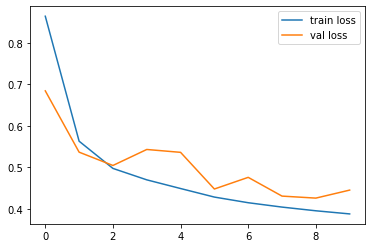

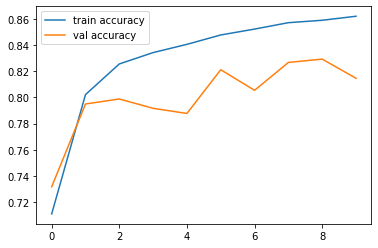

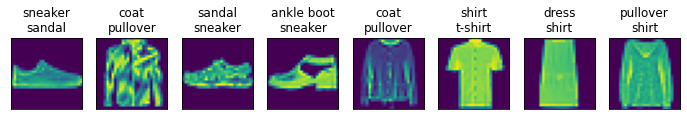

In [12]:
class MLPWeightDecay(nn.Module):
    #TODO: Add a wd parameter to the init method with a default value of 0.001
    def __init__(self, num_outputs, num_hiddens, lr,wd = 0.001):
        super().__init__()

        self.num_num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        self.lr = lr
        #TODO: Add the wd parameter as a class attribute to use in the optimizer
        self.wd = wd
        #TODO: Use the same net you used in Q4 and Q5
        self.net = nn.Sequential(
            
            #TODO: Add a nn.Flatten()
            nn.Flatten(),
            #TODO: Add a nn.Linear with input=28*28 and output=num_hiddens
            nn.Linear(28*28,num_hiddens),
            #TODO: Add a nn.ReLU after the Linear Layer you define
            nn.ReLU(),
            #TODO: Add a nn.Linear with input=num_hiddens and output=num_outputs
            nn.Linear(num_hiddens,num_outputs)   

                                  )

    def forward(self, X):
        return self.net(X)

    def loss(self, Y_hat, Y, averaged=True):
      Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
      Y = Y.reshape((-1,))
      return F.cross_entropy(
          Y_hat, Y, reduction='mean' if averaged else 'none')

    def configure_optimizers(self):
        #TODO: Add a weight_decay argument to the SGD call with value self.wd
        return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.wd)


data = FashionMNIST(batch_size=256)
model = MLPWeightDecay(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)


#Fifth Classifier: MLP with dropout

**Q7: Add dropout to the MLP model**

We use dropout to turn off some neurons with a probability p to regularize the model and reduce overfitting.

Epoch: 0, train loss: 0.9206409931182862, val loss: 0.660777972638607                 train acc: 0.6869182180851063 val acc: 0.73857421875
Epoch: 1, train loss: 0.5991943809580296, val loss: 0.5591019161045552                 train acc: 0.791938164893617 val acc: 0.77646484375
Epoch: 2, train loss: 0.5299907057843309, val loss: 0.523595129698515                 train acc: 0.8144281914893617 val acc: 0.7880859375
Epoch: 3, train loss: 0.49047417234867174, val loss: 0.48144615441560745                 train acc: 0.8264461436170213 val acc: 0.80498046875
Epoch: 4, train loss: 0.46384781852681584, val loss: 0.5558832295238971                 train acc: 0.835405585106383 val acc: 0.7505859375
Epoch: 5, train loss: 0.44618796503290215, val loss: 0.4386635884642601                 train acc: 0.8413397606382979 val acc: 0.8224609375
Epoch: 6, train loss: 0.4316394434330311, val loss: 0.4257603093981743                 train acc: 0.8455452127659574 val acc: 0.82451171875
Epoch: 7, train loss: 0

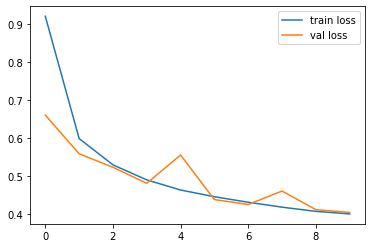

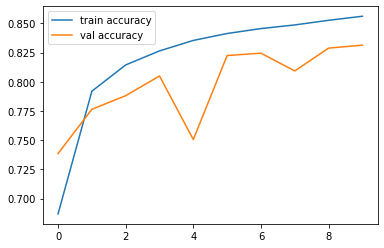

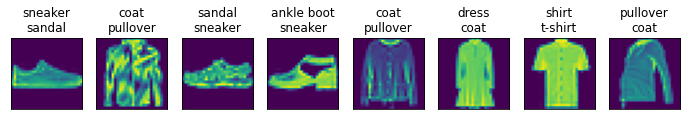

In [13]:
class MLPDropout(nn.Module):
    #TODO: Add a dropout parameter with a default value of 0.5
    def __init__(self, num_outputs, num_hiddens, lr, p = 0.5):
        super().__init__()

        self.num_num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        self.lr = lr
        
        #TODO: Use the same net in Q4, Q5, and Q6

        #TODO: Add a nn.Dropout(p) after the ReLU activation
        #      where p is the dropout parameter
        self.net = nn.Sequential(
            #TODO: Add a nn.Flatten()
            nn.Flatten(),
            #TODO: Add a nn.Linear with input=28*28 and output=num_hiddens
            nn.Linear(28*28,num_hiddens),
            #TODO: Add a nn.ReLU after the Linear Layer you define
            nn.ReLU(),
            nn.Dropout(p),
            #TODO: Add a nn.Linear with input=num_hiddens and output=num_outputs
            nn.Linear(num_hiddens,num_outputs)   
            
                                 )

    def forward(self, X):
        return self.net(X)

    def loss(self, Y_hat, Y, averaged=True):
      Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
      Y = Y.reshape((-1,))
      return F.cross_entropy(
          Y_hat, Y, reduction='mean' if averaged else 'none')

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)


data = FashionMNIST(batch_size=256)
model = MLPDropout(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)


<h1>That's it!</h1>
This is optional, but feel free to change the number of hidden units in each hidden layer, change various hyperparameters like dropout probability, learning rate, batch size, and number of epochs. 

You can also experiment with adding more hidden layers and seeing how the loss and accuracy change. Does increasing regularization help when increasing the number of hidden layers?

Attribution: Code in this notebook was based on code from [Dive Into Deep Learning](https://d2l.ai/)